# Canny滤波器

In [1]:
#coding:utf-8
%matplotlib inline
import numpy as np
import scipy
from scipy.special import comb
import matplotlib.pyplot as plt
import cv2
from scipy import stats

In [2]:
src = cv2.imread('../../datas/f4.jpg',0)
rgb = cv2.cvtColor(cv2.imread('../../datas/f4.jpg'),cv2.COLOR_BGR2RGB)

In [3]:
def add_syn_border(u,padsize,Xind,Yind):
    # add_border of width 5 to get an output image of size [256,256] 

    m, n = Xind.shape
    p1, p2 = padsize

    v = zeros((m, n))
    v[p1 : m-p1, p2 : n-p2] = u
    for i in r_[xrange(p1), xrange(m-p1, m)]:
        for j in xrange(n):
            v[i, j] = v[Xind[i, j],Yind[i, j]]
    for i in xrange(p1, m-p1):
        for j in r_[xrange(p2), xrange(n-p2, n)]:
            v[i, j] = v[Xind[i, j],Yind[i, j]]
    return v

In [11]:
def padarray(A, padsize, method='zero', direction='both',
      Xind=None, Yind=None):
    """
    pads array A using the specified method and direction. 
    method can be one of these strings: 
       'zero'           Pads with zeros
       'perodic'        Pads with circular repetitiion of elements
       'symmetric'      Pads array with mirror reflections of itself 
       'antisymmetric'  Pads array with point reflections of itself 
       'synthteic'      Pads array with synthetic boundary conditions
    direction can be one of the following strings.  
       'pre'            Pads before the first array element along each
                        dimension .
       'post'           Pads after the last array element along each
                        dimension. 
       'both'           Pads before the first array element and after the
                        last array element
    Example:
    >>> from numpy import arange
    >>> from padarray import padarray
    >>> n = 5
    >>> A = arange(n ** 2)
    >>> A.shape = (n, n)
    >>> padsize = (2,3)
    >>> B = padarray(A,padsize,'periodic','both')
    >>> B
    array([[17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17],
           [22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22],
           [ 2,  3,  4,  0,  1,  2,  3,  4,  0,  1,  2],
           [ 7,  8,  9,  5,  6,  7,  8,  9,  5,  6,  7],
           [12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12],
           [17, 18, 19, 15, 16, 17, 18, 19, 15, 16, 17],
           [22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22],
           [ 2,  3,  4,  0,  1,  2,  3,  4,  0,  1,  2],
           [ 7,  8,  9,  5,  6,  7,  8,  9,  5,  6,  7]])
    """

    a0, a1 = A.shape
    p0, p1 = padsize

    if method == 'zero':
        if direction == 'pre':
            B = np.zeros((a0 + p0, a1 + p1))
            B[p0 : p0 + a0, p1 : p1 + a1] = A          
        elif direction == 'post':
            B = np.zeros((a0 + p0, a1 + p1))
            B[0 : a0, 0 : a1] = A          
        elif direction == 'both':
            B = np.zeros((a0 + 2*p0, a1 + 2*p1))
            B[p0 : p0 + a0, p1 : p1 + a1] = A          

    elif method == 'periodic':
        if direction == 'pre':
            B = A[ix_(range(-p0, a0), range(-p1, a1))]
        elif direction == 'post':
            B = A[ix_(mod(range(0,a0 + p0), a0), mod(range(0,a1 + p1), a1))]
        elif direction == 'both':
            B = A[ix_(mod(range(-p0,a0+p0), a0), mod(range(-p1,a1+p1), a1))]

    elif method == 'reflexive':
        if direction == 'pre':
            B = A[ix_(range(p0-1, -1, -1) + range(0, a0),
                      range(p1-1, -1, -1) + range(0, a1))]
        elif direction == 'post':
            B = A[ix_(range(0, a0) + range(a0-1, a0-p0-1, -1),
                      range(0, a1) + range(a1-1, a1-p1-1, -1))]
        elif direction == 'both':
            B = A[ix_(range(p0-1,-1,-1)+range(0,a0)+range(a0-1,a0-p0-1,-1),
                      range(p1-1,-1,-1)+range(0,a1)+range(a1-1,a1-p1-1,-1))]
    
    elif method == 'antireflexive':
        if direction == 'pre':
            B0 = A[ix_([0]*p0 + range(0, a0),
                       [0]*p1 + range(0, a1))]
            B1 = A[ix_(range(p0, 0, -1) + range(0, a0),
                       range(p1, 0, -1) + range(0, a1))]
        elif direction == 'post':
            B0 = A[ix_(range(0, a0) + [a0-1]*p0,
                       range(0, a1) + [a1-1]*p1)]
            B1 = A[ix_(range(0, a0) + range(a0-2, a0-p0-2, -1),
                       range(0, a1) + range(a1-2, a1-p1-2, -1))]
        elif direction == 'both':
            B0 = A[ix_([0]*p0 + range(0, a0) + [a0-1]*p0,
                       [0]*p1 + range(0, a1) + [a1-1]*p1)]
            B1 = A[ix_(range(p0,0,-1)+range(0,a0)+range(a0-2,a0-p0-2,-1),
                       range(p1,0,-1)+range(0,a1)+range(a1-2,a1-p1-2,-1))]
        B = 2 * B0 - B1
    elif method == 'synthetic':
        B = add_syn_border(A, padsize, Xind, Yind)
    return B 

In [12]:
def canny(src):
    img = src.astype(np.float64) / 255.0
    # 平滑滤波器
    filter_kernel = np.array([
        [2, 4, 5, 4, 2],
             [4, 9, 12 ,9, 4],
             [5, 12 ,15, 12, 5],
             [4, 9 ,12, 9 ,4],
             [2, 4 ,5 ,4, 2],
    ],dtype=np.float64) / 115.0
    
    im_conv = cv2.filter2D(img,-1,filter_kernel)
    
    # 计算梯度
    gradientX_mask = np.array([
        [-1,0,1],
        [-2,0,2],
        [-1,0,1]
    ],dtype=np.float64)
    gradientY_mask = np.array([
        [1,2,1],
        [0,0,0],
        [-1,-2,-1]
    ],dtype=np.float64)
    gradx = cv2.filter2D(img,-1,gradientX_mask)
    grady = cv2.filter2D(img,-1,gradientY_mask)
    absgrad = np.abs(gradx) + np.abs(grady)
    
    # 计算梯度角
    rows,cols = src.shape[0],src.shape[1]
    theta = np.zeros((rows,cols))
    eps = 1.0e-5
    idx = (gradx == 0)
    theta[idx] = np.arctan(grady[idx]/eps)
    theta[~idx] = np.arctan(grady[~idx] / (gradx[~idx] + eps))
    
    theta = theta * (180.0 / np.pi)
    idx = (theta < 0)
    theta[idx] = theta[idx] - 90
    theta[idx] = np.abs(theta[idx])
    
    idx1 = ((theta > 0) & (theta < 22.5)) | ((theta > 157.5) & (theta < 181))
    idx2 = ((theta > 22.5) & (theta < 67.5))
    idx3 = (67.5<theta)& (theta<112.5)
    idx4 = (112.5<theta)&(theta<157.5)
    
    theta[idx1] = 0
    theta[idx2] = 45
    theta[idx3] = 90
    theta[idx4] = 135
    # 非极大值抑制
    canny_im = padarray(absgrad,padsize = (1,1))
    for i in range(1,rows-1):
        for j in range(1,cols - 1):
            if theta[i,j] == 135:
                if (canny_im[i-1,j+1]>canny_im[i,j]) or (canny_im[i+1,j-1]>canny_im[i,j]):
                    canny_im[i,j] = 0
            elif theta[i,j] == 45:
                if (canny_im[i+1,j+1]>canny_im[i,j]) or (canny_im[i-1,j-1]>canny_im[i,j]):
                    canny_im[i,j] = 0
            elif theta[i,j] == 90:
                if (canny_im[i,j+1]>canny_im[i,j]) or (canny_im[i,j-1]>canny_im[i,j]):
                    canny_im[i,j] = 0
            elif theta[i,j] == 0:
                if (canny_im[i+1,j]>canny_im[i,j]) or (canny_im[i-1,j]>canny_im[i,j]):
                    canny_im[i,j] = 0
    return canny_im

In [13]:
dst = canny(src)

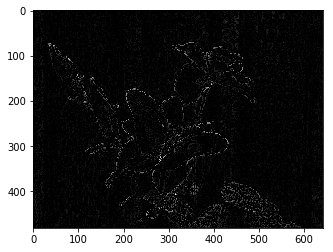

In [14]:
plt.imshow(dst,'gray')